In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, collect_list, size
from pyspark.sql.window import Window
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, DoubleType
from pyspark.ml.linalg import VectorUDT
from pyspark.sql import Row
from pyspark.ml.regression import LinearRegression
import matplotlib.pyplot as plt


In [ ]:
# Khởi tạo SparkSession
spark = SparkSession.builder.appName("GoldPricePrediction").getOrCreate()

# Đọc dữ liệu
df = spark.read.csv("/content/drive/MyDrive/gold_prices.csv", header=True, inferSchema=True)


In [ ]:
# Chuyển đổi và sắp xếp theo ngày
df = df.withColumn("Date", to_date(col("Date"), "yyyy-MM-dd")).orderBy("Date")

# Cửa sổ sliding
window_size = 10
w = Window.orderBy("Date").rowsBetween(-window_size, -1)

# Gom giá trị "Buy Price" của 10 ngày trước thành danh sách
df_sliding = df.withColumn("features_array", collect_list("Buy Price").over(w)) \
               .withColumn("label", col("Buy Price"))

# Lọc bỏ những dòng chưa đủ window_size
df_filtered = df_sliding.filter(size("features_array") == window_size)

# Chuyển đổi mảng thành vector để huấn luyện
to_vector_udf = udf(lambda x: Vectors.dense(x), VectorUDT())
final_df = df_filtered.withColumn("features", to_vector_udf("features_array")) \
                      .select("features", "label")

In [ ]:
# Chia tập train/test
train_df, test_df = final_df.randomSplit([0.7, 0.3], seed=42)

# Huấn luyện mô hình hồi quy tuyến tính


# Kết quả
training_loss = lr_model.summary.objectiveHistory
print("Training loss history:", training_loss)

Training loss history: [0.4998738647830469, 0.0007286835607196996, 0.0007286835607196996, 0.0006482991827896307, 0.0006466313458672524, 0.0003221615588584742, 0.00029903212127556757, 0.00021554815501628505, 0.00020920501610438872, 0.0002036434251612107, 0.0002028124011857414, 0.0002026385967947029, 0.00020261238255865196, 0.0002026032573490553, 0.00020260303883219, 0.00020260300804860715, 0.0002026030079732263, 0.00020260300180812246, 0.00020260300083644922, 0.00020260300064638798, 0.00020260300060601322, 0.0002026030005600117, 0.00020260300053199002, 0.00020260300049973405, 0.00020260300046689268]


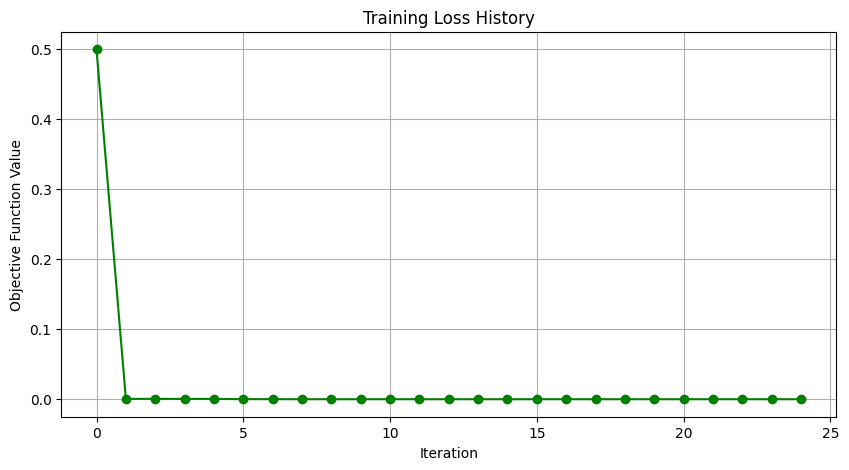

In [ ]:
# Vẽ biểu đồ training loss
plt.figure(figsize=(10, 5))
plt.plot(training_loss, marker='o', linestyle='-', color='green')
plt.title("Training Loss History")
plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.grid(True)
plt.show()

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Dự đoán trên tập test
predictions = lr_model.transform(test_df)

# Tính RMSE
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("RMSE on test data =", rmse)


RMSE on test data = 0.3319684757006266


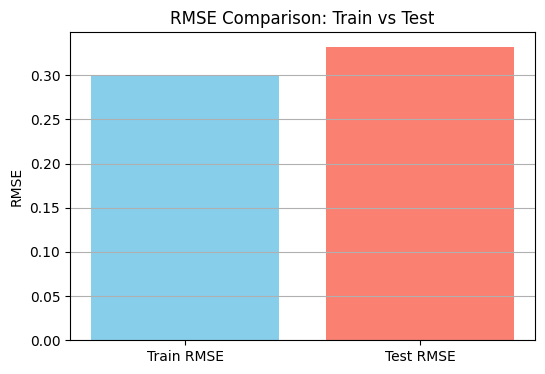

In [ ]:
# Tính RMSE cho train
train_pred = lr_model.transform(train_df)
train_rmse = evaluator.evaluate(train_pred)

# Tính RMSE cho test
test_pred = lr_model.transform(test_df)
test_rmse = evaluator.evaluate(test_pred)

# Bar chart
plt.figure(figsize=(6, 4))
plt.bar(["Train RMSE", "Test RMSE"], [train_rmse, test_rmse], color=['skyblue', 'salmon'])
plt.title("RMSE Comparison: Train vs Test")
plt.ylabel("RMSE")
plt.grid(axis='y')
plt.show()
